In [1]:
import torch
import numpy as np
import pandas as pd

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [65]:
from transformers import BertTokenizer, BertModel, AutoModelForSequenceClassification, AdamW, get_scheduler
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')                                                     
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=314)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [3]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW, get_scheduler
model_name = "sberbank-ai/sbert_large_nlu_ru"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=314)
#попробуем позже

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/sbert_large_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
#load best model
model.load_state_dict(torch.load("../../best_model3004/pytorch_model.bin", map_location=device))

<All keys matched successfully>

In [5]:
torch.cuda.empty_cache()
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024

In [77]:
df = pd.read_csv("../../draft.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['id'] = pd.Series(df['id']).astype(str)

In [78]:
g_id = []
for id in df['id']:
    if len(id) == 10:
        g_id.append(str(id)[:4])
    else:
        g_id.append('0' + str(id)[:3])
df['g_id'] = g_id

In [81]:
df.value_counts('g_id')

g_id
4011    9837
9503    8636
8708    6086
7318    2991
3926    2246
        ... 
8427      22
7615      21
5404      21
5609      21
4910      21
Length: 314, dtype: int64

In [80]:
min_req = 20
filtered_classes = df.g_id.value_counts()[df.g_id.value_counts() > min_req].index.values

df = df[df.g_id.apply(lambda x: True if x in filtered_classes else False)]
df

,id,label,g_id
6,805102000,плоды цитрусовых культур апельсины свежие,0805
7,805210000,плоды цитрусовых культур мандарины свежие,0805
8,805290000,пробы и образцы для проведения работ по оценке...,0805
9,805501000,плоды цитрусовых культур лимоны свежие,0805
10,808108002,яблоки свежие в коробках сорт royal gala в...,0808
...,...,...,...
87483,1704907500,сливочные конфеты не содержащие какао тм sto...,1704
87484,1704907500,пищевой наполнитель для пром произв ва пищевой...,1704
87485,1704907500,тоффи карамели и аналогичные сладости не содер...,1704
87486,1704907500,кондитерские изделия из сахара не содержащие к...,1704


In [128]:
counts = df.value_counts('id')
df_count = pd.DataFrame(data={'id': counts.index, 'count': counts.values})

In [58]:
df_count.to_csv('../../tnveds_sort.csv')

In [74]:
df

,description,labels
0,фитинги для труб или трубок из коррозинностойк...,138
1,инструмент для демонтажа декоративной крышки к...,43
2,бумага из целлюлозных волокон для использовани...,63
3,6600005819 регулятор высоты ремня безопасности...,177
4,упаковка стеклянная для парфюмерно косметическ...,129
...,...,...
86037,игрушки детские имеющие встроенный двигатель ...,295
86038,8891428999 rear bumper body upr верхний элемен...,259
86039,светильники электрические поставляются частич...,294
86040,6666056178 compl a side structure lh левая бок...,259


In [130]:
df = df[df['label'].notnull()]

In [82]:
df['label'] = df['label'].apply(lambda x: ' '.join(x.split()[:400]) if len(x.split())>400 else x)

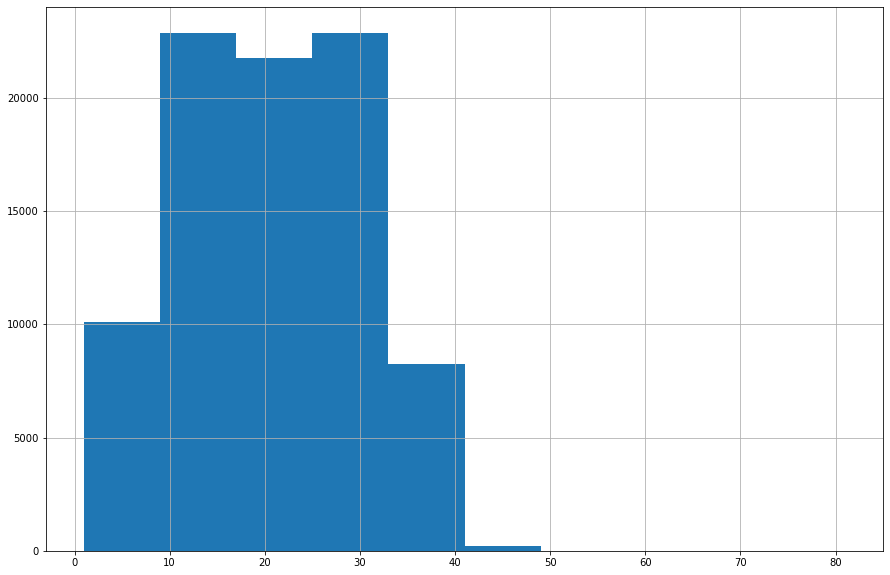

In [41]:
a = df['label'].apply(lambda x: len(x.split())).hist(figsize=(15, 10))

In [83]:
df['label'][df['label'].apply(lambda x: True if len(x.split()) == 1 else False)]

9755         патрубок
10006           хомут
15540          стулья
19710         домкрат
20438        расчёска
             ...     
86179            воск
86517         тoвары 
86655    аhтибиотики 
86931     дипиридaмол
87003     эторикоксиб
Name: label, Length: 92, dtype: object

In [84]:
from sklearn import preprocessing
Label_encoder = preprocessing.LabelEncoder()
Label_encoder.fit(df['g_id'])

LabelEncoder()

In [85]:
df['g_id'] = Label_encoder.fit_transform(df['g_id'])

In [86]:
df.drop('id', axis=1, inplace=True)

In [87]:
df.columns = ['description', 'labels']

In [88]:
df.to_csv('../../label_enc.csv', index=False)

In [89]:
np.save('./classes.npy', Label_encoder.classes_)

In [90]:
df = df.sample(frac=1).reset_index(drop=True)
train = df[:int(len(df)*0.8)]
test =  df[int(len(df)*0.8):]

In [93]:
print(len(test['labels'].value_counts()))

314


In [92]:
train.to_csv('../../train.csv', index=False)
test.to_csv('../../test.csv', index=False)

In [36]:
model.named_parameters

<bound method Module.named_parameters of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              

In [95]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [5]:
#!pip install datasets

In [6]:
from datasets import load_dataset, load_metric
dataset = load_dataset('csv', data_files={'train': '../../train.csv', 'test': '../../test.csv'})

Found cached dataset csv (/home/sincosxy/.cache/huggingface/datasets/csv/default-47682a937c9addd8/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
dataset = dataset.map(lambda e: tokenizer(e['description'], truncation = True, max_length=100, padding='max_length'), batched=True)

Loading cached processed dataset at /home/sincosxy/.cache/huggingface/datasets/csv/default-47682a937c9addd8/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-32e301bb9fe264f0.arrow


Map:   0%|          | 0/17209 [00:00<?, ? examples/s]

In [8]:
pytorch_style_columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']  # 
dataset = dataset.remove_columns(set(dataset['train'].features.keys()) - set(pytorch_style_columns))

In [9]:
set(dataset['train'].features.keys())


{'attention_mask', 'input_ids', 'labels', 'token_type_ids'}

In [10]:
dataset.set_format(type='torch', columns=pytorch_style_columns, device='cuda') 

In [101]:
dataset.shape

{'train': (68833, 4), 'test': (17209, 4)}

In [12]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=8)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=8)
#если есть видеопамять около 10гб, можно поставить 8

In [103]:
len(train_dataloader)

8605

In [13]:

optimizer = AdamW(model.parameters(), lr=2e-6)

num_epochs = 15

num_training_steps = num_epochs * len(train_dataloader)


lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=2000,
    num_training_steps=num_training_steps
)

/home/sincosxy/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
torch.cuda.empty_cache()
import gc
gc.collect()

69

In [15]:
from tqdm import tqdm

In [21]:
#next(iter(train_dataloader))
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024

In [107]:
num_epochs = 15

In [22]:
best_f1 = 0.
show_train_loss_every_num_epoch = 0.1

for epoch in range(num_epochs):
    print(40*'-', '\nepoch', epoch+1)
    model.train()
    losses = []

    for i, batch in enumerate(tqdm(train_dataloader)):
        model.train()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        losses.append(loss.item())

        #f i%int(len(train_dataloader)*show_train_loss_every_num_epoch)==int(len(train_dataloader)*show_train_loss_every_num_epoch)-1:
    print(f'train loss [{i*100/len(train_dataloader):.2f}%]: {np.array(losses).mean():.3f}')
    losses = []
    print('\nvalidating')

    f1 = load_metric('f1')
    acc = load_metric('accuracy')
    precision = load_metric('precision')
    recall = load_metric('recall')
    with torch.no_grad():
        model.eval()
                
        for batch in tqdm(test_dataloader):
        ##for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            f1.add_batch(predictions=predictions, references=batch["labels"])    
            acc.add_batch(predictions=predictions, references=batch["labels"])    
            precision.add_batch(predictions=predictions, references=batch["labels"])    
            recall.add_batch(predictions=predictions, references=batch["labels"])    

        print('weighted summary:')
        print('Test acc:', acc.compute()['accuracy'])
        print('Test precision:', precision.compute(average = 'weighted')['precision'])
        print('Test recall:', recall.compute(average = 'weighted')['recall'])
        f1_weighted = f1.compute(average = 'weighted')['f1']
        print('Test f1:', f1_weighted, '\n')

        if f1_weighted > best_f1:
            best_f1 = f1_weighted
            model.save_pretrained("../../best_model3004")

    model.train()

---------------------------------------- 
epoch 1


100%|████████████████████████████████████████████████████████████████████████████| 8605/8605 [39:31<00:00,  3.63it/s]
/tmp/ipykernel_3371/2632351315.py:25: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  f1 = load_metric('f1')


train loss [99.99%]: 1.752

validating


100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:47<00:00, 12.85it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weighted summary:
Test acc: 0.7996978325294903
Test precision: 0.7550712276549277
Test recall: 0.7996978325294903
Test f1: 0.7565272150455988 

---------------------------------------- 
epoch 2


100%|████████████████████████████████████████████████████████████████████████████| 8605/8605 [39:36<00:00,  3.62it/s]


train loss [99.99%]: 1.111

validating


100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:47<00:00, 12.84it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weighted summary:
Test acc: 0.8681503864257075
Test precision: 0.8459054347633016
Test recall: 0.8681503864257075
Test f1: 0.8455024629346195 

---------------------------------------- 
epoch 3


100%|████████████████████████████████████████████████████████████████████████████| 8605/8605 [39:33<00:00,  3.62it/s]


train loss [99.99%]: 0.742

validating


100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:47<00:00, 12.83it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weighted summary:
Test acc: 0.9027253181474809
Test precision: 0.8931912224935824
Test recall: 0.9027253181474809
Test f1: 0.890272293256992 

---------------------------------------- 
epoch 4


100%|████████████████████████████████████████████████████████████████████████████| 8605/8605 [39:35<00:00,  3.62it/s]


train loss [99.99%]: 0.508

validating


100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:47<00:00, 12.85it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weighted summary:
Test acc: 0.9209134755070022
Test precision: 0.9149767300881549
Test recall: 0.9209134755070022
Test f1: 0.9131829588454822 

---------------------------------------- 
epoch 5


100%|████████████████████████████████████████████████████████████████████████████| 8605/8605 [39:35<00:00,  3.62it/s]


train loss [99.99%]: 0.357

validating


100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:47<00:00, 12.85it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weighted summary:
Test acc: 0.9348596664535999
Test precision: 0.9317281053634626
Test recall: 0.9348596664535999
Test f1: 0.9302193516209848 

---------------------------------------- 
epoch 6


100%|████████████████████████████████████████████████████████████████████████████| 8605/8605 [39:34<00:00,  3.62it/s]


train loss [99.99%]: 0.257

validating


100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:47<00:00, 12.85it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weighted summary:
Test acc: 0.9422395258295078
Test precision: 0.9428444020839998
Test recall: 0.9422395258295078
Test f1: 0.9395694212122289 

---------------------------------------- 
epoch 7


100%|████████████████████████████████████████████████████████████████████████████| 8605/8605 [39:34<00:00,  3.62it/s]


train loss [99.99%]: 0.190

validating


100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:47<00:00, 12.85it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weighted summary:
Test acc: 0.9446220001162182
Test precision: 0.946227708983164
Test recall: 0.9446220001162182
Test f1: 0.9436794408198166 

---------------------------------------- 
epoch 8


100%|████████████████████████████████████████████████████████████████████████████| 8605/8605 [39:35<00:00,  3.62it/s]


train loss [99.99%]: 0.144

validating


100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:47<00:00, 12.86it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weighted summary:
Test acc: 0.9479923295949794
Test precision: 0.9495223308880203
Test recall: 0.9479923295949794
Test f1: 0.947315335451981 

---------------------------------------- 
epoch 9


100%|████████████████████████████████████████████████████████████████████████████| 8605/8605 [39:34<00:00,  3.62it/s]


train loss [99.99%]: 0.113

validating


100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:47<00:00, 12.85it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weighted summary:
Test acc: 0.9490964030449184
Test precision: 0.9502615137995498
Test recall: 0.9490964030449184
Test f1: 0.948790640907274 

---------------------------------------- 
epoch 10


100%|████████████████████████████████████████████████████████████████████████████| 8605/8605 [39:34<00:00,  3.62it/s]


train loss [99.99%]: 0.091

validating


100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:47<00:00, 12.86it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weighted summary:
Test acc: 0.9500842582369691
Test precision: 0.9518276316398866
Test recall: 0.9500842582369691
Test f1: 0.949821705481887 

---------------------------------------- 
epoch 11


100%|████████████████████████████████████████████████████████████████████████████| 8605/8605 [39:34<00:00,  3.62it/s]


train loss [99.99%]: 0.074

validating


100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:47<00:00, 12.85it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weighted summary:
Test acc: 0.9493869486896391
Test precision: 0.9514084970219272
Test recall: 0.9493869486896391
Test f1: 0.9493429811746151 

---------------------------------------- 
epoch 12


 61%|██████████████████████████████████████████████▌                             | 5265/8605 [24:13<15:21,  3.62it/s]


KeyboardInterrupt: 

In [16]:
from sklearn import preprocessing
from sklearn.metrics import classification_report
Label_encoder = preprocessing.LabelEncoder()
Label_encoder.classes_ = np.load('./classes.npy', allow_pickle=True)

true = []
preds = []

model.eval()
for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    true += batch["labels"].detach().cpu().numpy().tolist()
    preds += predictions.detach().cpu().numpy().tolist()

print(classification_report(Label_encoder.inverse_transform(true), Label_encoder.inverse_transform(preds)))

100%|████████████████████████████████████████████████████████████████████████████| 2152/2152 [02:45<00:00, 13.01it/s]
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        0805       0.00      0.00      0.00         9
        0808       1.00      0.38      0.55        16
        1704       0.38      1.00      0.56        80
        1905       0.00      0.00      0.00        14
        2003       0.88      1.00      0.94        15
        2007       0.00      0.00      0.00         7
        2009       0.00      0.00      0.00         8
        2105       0.00      0.00      0.00         8
        2106       1.00      0.17      0.29        30
        2202       0.00      0.00      0.00         3
        2710       0.00      0.00      0.00         8
        2918       0.00      0.00      0.00        29
        2924       0.00      0.00      0.00        27
        2933       0.19      0.76      0.31        55
        2934       0.00      0.00      0.00        36
        2941       0.00      0.00      0.00        22
        3005       1.00      1.00      1.00        14
        3206       1.00    

/home/sincosxy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
inputs = tokenizer('покрышки', truncation = True, max_length=100, padding='max_length', return_tensors="pt")
#batch = {k: torch.tensor(v).to(device) for k, v in txt.items()}
model.to(torch.device('cpu'))
with torch.no_grad():
    logits = model(**inputs).logits
predicted_class_id = logits.argmax().item()
#Label_encoder.inverse_transform(predicted_class_id)
a = []
a.append(predicted_class_id)

In [114]:
Label_encoder.inverse_transform([a])

array(['4011'], dtype=object)

In [17]:
def predict_class(text):
    model.to(torch.device('cpu'))
    inputs = tokenizer(text, truncation = True, max_length=100, padding='max_length', return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        return Label_encoder.inverse_transform([predicted_class_id])


In [19]:
print(predict_class("Велосипед"), predict_class("велосипед"), predict_class("Велосипедов"))

['9503'] ['9503'] ['8714']
